In [227]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import pandas
import scipy.stats as st
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize

In [228]:
def model(x,olambda,omega_m ):
    # print(olambda,omega_m)
    cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda-omega_m )
    x = x[0]
    DL = cosmo.luminosity_distance(x)
    distanceModulus = 5 * np.log10(DL.value)+25
    return distanceModulus

In [229]:
file = pandas.read_csv("supernovaData.csv")
sigma = np.mean(file['sigma'])
len(file['sigma'])
data = [file['redshift'],file['modDist']]

In [230]:
L = 1. #Range of x-data
M = 100 # Number of data points
x = file['redshift']

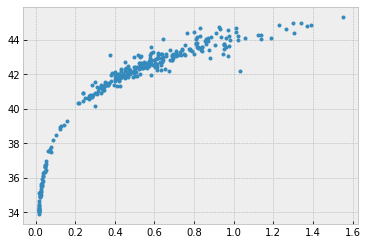

In [231]:
plt.plot(file['redshift'],file['modDist'],'.')

In [232]:
def logprior(theta,cmin,cmax,mmin,mmax,):
    ''' The natural logarithm of the prior probability. '''
    lp = 0.
    # unpack the model parameters from the tuple
    
    olambda, om = theta

    # uniform prior on c
    # print(om)

    cmin = 0. # lower range of prior
    cmax = 1# upper range of prior
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < om < cmax else -np.inf
    
     # uniform prior on m
    mmin = 0. # lower range of prior
    mmax = 1  # upper range of prior
  
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp += 0. if mmin < olambda < mmax else -np.inf
    
    return lp

In [233]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''
    # unpack the model parameters
  
    olambda, om = theta

  
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lin_md = model(x,olambda,om)
    # evaluate the model
    like = -0.5 * np.sum(((lin_md - data[1])/sigma)**2)
    # print(like)
    # return the log likelihood
    return like


In [234]:
def logpost(theta, data, sigma, x,cmin,cmax,mmin,mmax,):
    '''The natural logarithm of the posterior.'''
    return logprior(theta,cmin,cmax,mmin,mmax,) + loglike(theta, data, sigma, x)

In [235]:
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.
start = 0.01 * np.random.randn(nwalkers,2) # Initial positions of the walkers.
t0 = time.time()
samples = 0.01 * np.random.randn(len(x),2)


In [236]:
def getSamples(nwalkers):
    theta0 = []
    for j in range(nwalkers): theta0.append(np.abs(np.random.rand())) 
    i = 0
    theta1 = []
    while i<nwalkers:
        val = np.abs(np.random.rand())
        if (1-val-theta0[i]) > 0:
            theta1.append(val)
            i = i + 1
    return np.array([theta0,theta1])


In [254]:

    
def guassian_proposal(theta_curr):
    theta = []
    theta.append(np.abs(np.random.rand())) 
    i = 0
    while i < 1:
        val = np.abs(np.random.rand())
        if (1-val-theta[0]) > 0:
            theta.append(val)
            i += 1
    
    return theta

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q =  0.07*np.abs(st.norm(loc=x1, scale=1).pdf(x2))
    return q

def mcmc_mh_posterior(X, theta_init,sigma,x,nwalkers, cmin,cmax,mmin,mmax,func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    chains = []
    for j in range(nwalkers):
        thetas = []
        theta_curr = theta_init.T[j]
        # print(theta_curr)
        accept_rates = []
        accept_cum = 0
        acceptance_prob = np.array([[0,0]])
        for i in range(1, n_iter+1):
            theta_new = proposal_func(theta_curr)

            prob_curr = func(theta_curr,X,sigma,x,cmin,cmax,mmin,mmax,)
            # print('theta_new',theta_new)
            prob_new = func(theta_new,X,sigma,x,cmin,cmax,mmin,mmax,)
            
            # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
    
            if prob_new > prob_curr:
                acceptance_ratio = 1,1
            else:
                qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
                # print('qr',qr)
                acceptance_ratio = np.exp(prob_new - prob_curr) * qr
                
            acceptance_prob = np.append(acceptance_prob,[[min(1, acceptance_ratio[0]),min(1, acceptance_ratio[1])]], axis = 0)

            if acceptance_prob[i][0] > acceptance_prob[i-1][0] and  acceptance_prob[i][0] > acceptance_prob[i-1][1]:
                theta_curr = theta_new
                accept_cum = accept_cum+1
                # print('acc theta_new',theta_new)
                thetas.append(theta_new)
            else:
                thetas.append(theta_curr)
                
            accept_rates.append(accept_cum/i)
        chains.append(thetas)
        
    return chains, accept_rates


# generate observed data
X = data
nwalkers = 3
ndim = 2
cmin = .5
cmax = 1.5
mmin = 2
mmax = 5
initSamples = getSamples(nwalkers)
# print(initSamples)
# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, initSamples,sigma,x, nwalkers,cmin,cmax,mmin,mmax,
                                         logpost, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=1000)


In [258]:
m_theta = []
c_theta = []
chains = []
for i in range(nwalkers):
    m_theta = []
    c_theta = []
    for j in range(len(thetas[0])):
        c_theta.append(thetas[i][j][0])
        m_theta.append(thetas[i][j][1])
    chains.append([c_theta,m_theta]) 


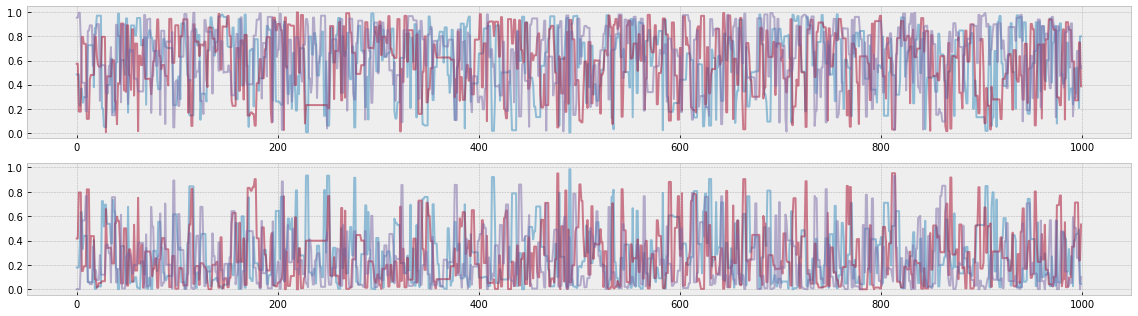

In [259]:


plt.figure(figsize=(16,1.5*nwalkers))

for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    for i in range(nwalkers):
        plt.plot(chains[i][n][:], '-',alpha=0.5)
plt.tight_layout()
plt.show()

In [260]:
import seaborn as sns
import pandas
m = []
c = []
for i in range(len(chains[0][0])):
    meanM = []
    meanC = []
    for j in range(nwalkers):
        meanM.append(chains[j][1][i])
        meanC.append(chains[j][0][i])
    m.append(np.mean(meanM))
    c.append(np.mean(meanC))
m_fit = max(m)
c_fit = max(c) 

d = {'c': c, 'm': m}
c_fit = max(d['c']) 
chainData = pandas.DataFrame(d)
print(chainData)


            c         m
0    0.671387  0.199003
1    0.671387  0.199003
2    0.552426  0.324914
3    0.466069  0.386660
4    0.435111  0.545250
..        ...       ...
995  0.496543  0.474745
996  0.496543  0.474745
997  0.544893  0.328823
998  0.708315  0.094601
999  0.575593  0.225727

[1000 rows x 2 columns]


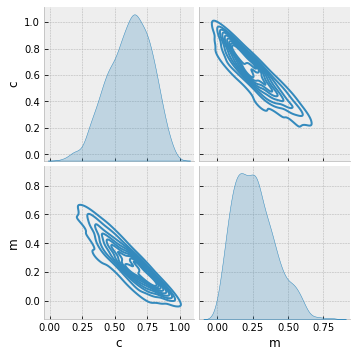

In [261]:
#sns.pairplot(chainData, kind="kde")
plt.style.use('bmh')
g = sns.pairplot(chainData, kind="kde")
i = 0
plt.show()


In [263]:
z=np.linspace(0.01,2,100)
cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - 0.58)
DL = cosmo.luminosity_distance(z) 
mu = 5 * np.log10(DL.value)+25


In [264]:
zchi=np.linspace(0.01,2,100)
def distance_Modulus(z, olambda):
  cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda)
  z = z.tolist()
  DL = cosmo.luminosity_distance(z) 
  distanceModulus = 5 * np.log10(DL.value)+25
  return distanceModulus
def chi2(params):
  olambda=params[0]
  model   = distance_Modulus(file['redshift'].to_numpy(), olambda) 
  return  np.sum((data[1] - model)**2./file['sigma'].to_numpy()**2)
res = minimize(chi2, x0=[0],method='L-BFGS-B', bounds=[(0,0.999)])
muChi = distance_Modulus(file['redshift'],res.x[0])
d = {'redshift':file['redshift'],'muChi':muChi}
muChi = pandas.DataFrame(d)
muChi = muChi.sort_values('muChi',ascending=True)

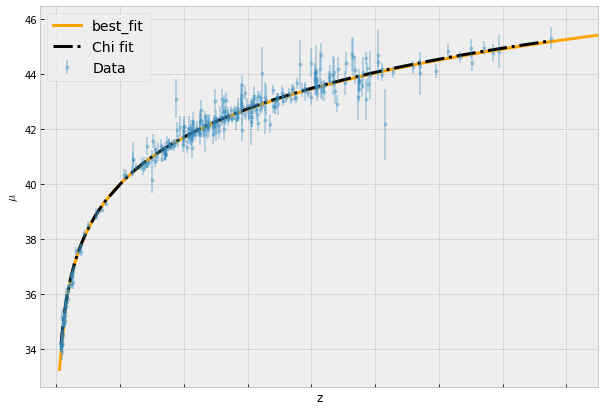

In [265]:
###
fig,ax1=plt.subplots(1,1,figsize=(10,7))
gs=gridspec.GridSpec(1,1)
colors=['b','orange']
###
ax1=plt.subplot(gs[0])


ax1.plot(z,mu, '-',color='orange', lw=3, label='best_fit')
ax1.plot(muChi['redshift'],muChi['muChi'], '-.',color='black', lw=3, label='Chi fit')
ax1.errorbar(file['redshift'],file['modDist'],yerr=file['sigma'].to_numpy(),fmt='.',alpha=0.3,label='Data')
###

ax1.legend(fontsize=14)
ax1.set_xlim(-.05,1.7)
models = ['linear model', 'quadratic model']
ax1.set_ylabel('$\mu$')
ax1.set_xlabel(r'z')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)